# Ethical Machine Learning 

## _Spotting and Preventing Proxy Bias_

#### Paige Bailey - 22 April 2018 (Editted For Python by Eric Schles)

-------------------

Machine learning systems often inherit biases against protected classes and historically disparaged groups via their training data [1](https://arxiv.org/pdf/1707.08120.pdf). Though some biases in features are straightforward to detect (ex: age, gender, race), others are not explicit and rely on subtle correlations in machine learning algorithms to detect. The incorporation of unintended bias into predictive models is called _proxy discrimination_.

---------------------

_Example of proxy bias in a bank's loan decision workflow._

![](ethical_bias.JPG)

---------------------

In this exercise, we will be implementing an example machine learning problem using decision trees, and determining whether its classification for loan recipients is biased against certain groups. We will explore several ways of detecting unintentional bias and removing it from our predictive model.

**Please note**: the techniques used in this exercise only support _linear models_, _decision trees_, _rule lists_, and _random forests_ - not deep learning models or neural networks. However, the supported models represent a significant fraction of models used in practice in predictive systems that operate on personal information, ranging from advertising [2](http://www.bing.com), psychopathy [3](http://www.bing.com), criminal justice [4](http://www.bing.com), [5](http://www.bing.com), and actuarial sciences [6](http://www.bing.com), [7](http://www.bing.com).


-------------------


## Step 0: Install and Load Required Packages

In [35]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn import linear_model
%matplotlib inline

### Define the purpose and goal of your machine learning product.

As you design the goal and the purpose of your machine learning product, you must first ask: **Who is your audience**?

* Is your product or analysis meant to include all people?
* And, if not: is it targeted to an exclusive audience?
* Is there a person on your team tasked specifically with identifying and resolving bias and discrimination issues?

Our audience for this product will be managers at a bank who are tasked with making decisions on who should be given loans - decidedly **not** a public audience. As data the data scientist assigned to this project, we can assume that we are responsible for resolving all bias and discrimination issues.

------------------------------------------

### Scope

After you have defined the concept of your machine learning problem, you need to **identify possible outcomes and define criteria that contribute to them**.

* How transparent will you be about the relationships between the inputs and the anticipated outcomes?
* Are there sensitive characteristics you need to monitor in your data in order to observe their effect on your outputs?

We will be extremely transparent with the managers, and likely less so with the bank's customers. Much of the data we will be dealing with is sensitive and personal - ages, addresses, credit histories, names, income.

* Could your expectations rely on unacknowledged bias of you and your team?

Absolutely - that is something that we are hoping to combat by examing any potential proxy bias. A way to check whether this analysis makes sense will be to ask a **diverse audience** if the expectations align with what is expected.

-------------------------------------------


### Data 

Once the concept and scope have been defined, it is time to focus on the acquisition, evaluation, and cleaning of data. We have received a single .csv file filled with information on customers from the bank's manager. Some questions to consider:

* Did the data come from a system prone to human error?
* Is the data current?
* What technology facilitated the collection of the data?
* Was participation of the data subjects voluntary?
* Does the context of the collection match the context of your use?
* Was your data collected by people or a system that was operating with quotas or a particular incentive structure?

To the best of our knowledge, the data does not come from a system prone to human error, is current, and has been accepted as valid by our customer, the bank's manager. We do not know what technology facilitated the data collection, and we can assume that the data was submitted voluntary by potential loan awardees (the context of our use). 

--------------------------------------------------

Now that your data has been collected, it would be a great idea to evaluate and describe it:

* Who is represented in the data?
* Who is under-represented or absent from your data?
* Can you find additional data, or use statistical methods, to make your data more inclusive?
* Was the data collected in an environment where data subjects had meaningful choices?
* How does the data reflect the perspective of the institution that collected it?
* Were fields within the data inferred or appended beyond what was clear to the data subject?
* Would this use of the data surprise the data subjects?

The next step would be cleaning the data.

* Are there any fields that should be eliminated from your data?
* Can you use anonymization or pseudonymization techniques to avoid needless evaluation or processing of individual data?

Several known fields of bias (`gender`, `age`, and `race`) will need to be removed from the data set. Thankfully, the .csv file has already been anonymized; names, specific birth dates, and exact addresses have been removed.

----------------------------


## Step 1: Import data 

The following is a synthetic data set, based heavily on the 1000-sample, open-source [German credit agency data set](http://archive.ics.uci.edu/ml/) hosted by UC Irvine. Four features were added: **zip code**, **race**, **gender**, and **status**. Racial and gender demographics by zip code are taken from 2010 United States Census data.

You can see that the factors in our .csv are a mix of numeric and categorical features.

In [36]:
credit = pd.read_csv("loans.csv")
credit.head()

,age,amount,checking_balance,credit_history,default,dependents,employment_duration,existing_loans_count,gender,housing,...,months_loan_duration,other_credit,percent_of_income,phone,purpose,race,savings_balance,status,years_at_residence,zipcode
0,26.0,8845.0,< 0 USD,excellent,yes,2.0,unknown,3.0,M,own,...,33.0,bank,1.0,no,education,SA,500 - 1000 USD,divorced,1.0,604
1,25.0,178.0,unknown,excellent,yes,3.0,unknown,0.0,M,other,...,52.0,stores,8.0,yes,education,AA,unknown,divorced,2.0,603
2,33.0,208.0,unknown,no credit,yes,2.0,3 - 5 years,1.0,F,rent,...,19.0,stores,15.0,yes,car,BA,500 - 1000 USD,divorced,9.0,611
3,78.0,6693.0,< 0 USD,good,no,1.0,< 1 year,1.0,M,other,...,57.0,none,6.0,no,car,SA,unknown,single,1.0,603
4,23.0,3621.0,< 0 USD,critical,yes,3.0,> 7 years,1.0,M,rent,...,20.0,bank,6.0,yes,business,AA,< 100 USD,single,15.0,610


In [37]:
# Change zip to a factor rather than a numeric value.
credit['zipcode'] = credit['zipcode'].astype(str)

### Constraining the data

#### Establishing logic for variables

* Can you describe the logic that connects the variables to the output of your equation?
* Do your variables have a causal relationship to the results they predict?
* How did you determine what weight to give each variable?

#### Identifying assumptions

* Will your variables apply equally across race, gender, age, disability, ethnicity, socioeconomic status, education, etc.?
* What are you assuming about the kinds of people in your data set?
* Would you be comfortable explaining your assumptions to the public?
* What assumptions are you relying on to determine the relevant variables and their weights?

#### Defining success

* What amount and type of error do you expect?
* How will you ensure your system is behaving the way you intend? How reliable is it?

Let's take a closer look at the checking and savings account balances, as well as racial demographics.

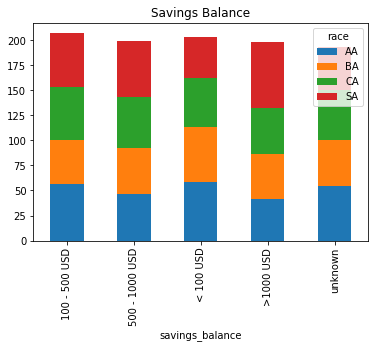

In [13]:
savings_race = credit.groupby(["savings_balance", "race"])["savings_balance"].count().unstack("race").fillna(0)
savings_race.plot(kind="bar", stacked=True, title="Savings Balance")
plt.show()

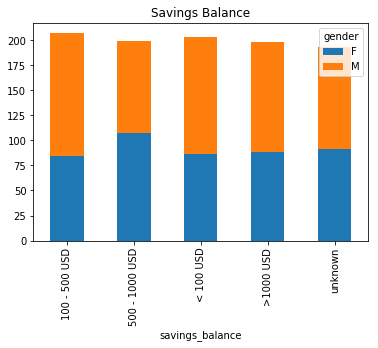

In [14]:
savings_gender = credit.groupby(["savings_balance", "gender"])["savings_balance"].count().unstack("gender").fillna(0)
savings_gender.plot(kind="bar", stacked=True, title="Savings Balance")
plt.show()

We can also take a closer look at percentages of savings account balances by race.

In [25]:
credit.groupby(["savings_balance", "race"]).size() / 10

savings_balance  race
100 - 500 USD    AA      5.6
                 BA      4.4
                 CA      5.3
                 SA      5.4
500 - 1000 USD   AA      4.6
                 BA      4.6
                 CA      5.1
                 SA      5.6
< 100 USD        AA      5.8
                 BA      5.5
                 CA      4.9
                 SA      4.1
>1000 USD        AA      4.2
                 BA      4.4
                 CA      4.6
                 SA      6.6
unknown          AA      5.4
                 BA      4.6
                 CA      5.0
                 SA      4.3
dtype: float64

Though ideally our model would apply equally regardless of socioeconomic status, our customer (the bank's executives) have argued that there is a business need to include this feature. Checking account and savings account balances will both be incorporated into our final model.

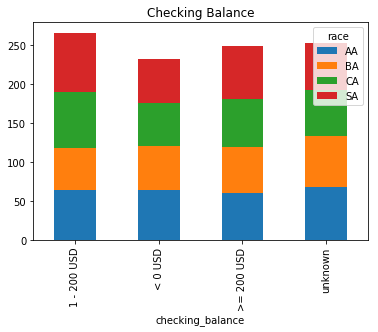

In [27]:
checking_race = credit.groupby(["checking_balance", "race"])["checking_balance"].count().unstack("race").fillna(0)
checking_race.plot(kind="bar", stacked=True, title="Checking Balance")
plt.show()

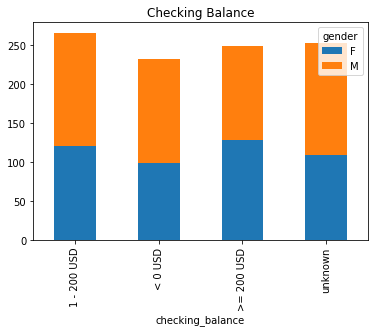

In [31]:
checking_gender = credit.groupby(["checking_balance", "gender"])["checking_balance"].count().unstack("gender").fillna(0)
checking_gender.plot(kind="bar", stacked=True, title="Checking Balance")
plt.show()

In [29]:
credit.groupby(["checking_balance", "race"]).size() / 10

checking_balance  race
1 - 200 USD       AA      6.4
                  BA      5.4
                  CA      7.2
                  SA      7.6
< 0 USD           AA      6.4
                  BA      5.7
                  CA      5.5
                  SA      5.6
>= 200 USD        AA      6.0
                  BA      5.9
                  CA      6.2
                  SA      6.8
unknown           AA      6.8
                  BA      6.5
                  CA      6.0
                  SA      6.0
dtype: float64

As you can see in the histogram below, the majority of our data set is Caucasian (**CA**) at 44.2%, closely followed by African American (**AA**) at 35.8%, and then Asian American (**AS**) at 13.6% and Hispanic or Mixed Race (**MR**) at 6.4%. 

In [30]:
credit.groupby(["race", "default"]).size() / 10

race  default
AA    no         12.2
      yes        13.4
BA    no         11.8
      yes        11.7
CA    no         10.9
      yes        14.0
SA    no         11.8
      yes        14.2
dtype: float64

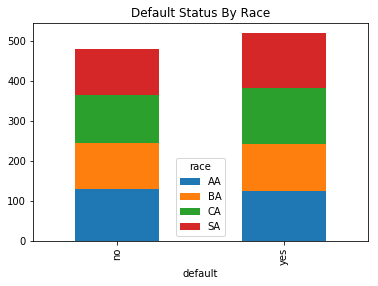

In [40]:
race_default = credit.groupby(["default", "race"])["default"].count().unstack("race").fillna(0)
race_default.plot(kind="bar", stacked=True, title="Default Status By Race")
plt.show()

When we break out the racial demographics by zip code, however, we see that it is obvious that race and address are linked. The 77005 and 77030 zip codes, located around West University and the Museum District, are predominantly Caucasian, while the 77021 and 77004 zip codes, in midtown and the __th__ ward, are predominantly African American.

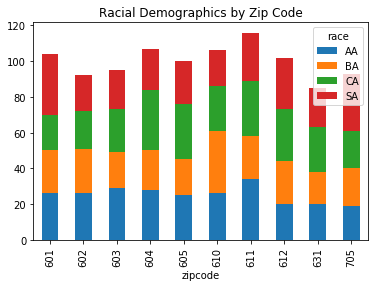

In [38]:
zipcode_race = credit.groupby(["zipcode", "race"])["zipcode"].count().unstack("race").fillna(0)
zipcode_race.plot(kind="bar", stacked=True, title="Racial Demographics by Zip Code")
plt.show()

![](htxzips.JPG)

In [41]:
credit["amount"].describe()

count    1000.000000
mean     4900.456000
std      2944.509393
min        11.000000
25%      2234.000000
50%      4909.500000
75%      7464.000000
max      9987.000000
Name: amount, dtype: float64

In [16]:
credit["amount"].head()

[1] 1169 7882 6948 1934 1237 1585

#### Dividing into training and testing data sets

Looks good to me! The first six values of `credit` and `credit_rand` are different, but the summary statistics look exactly the same. Now that we have a randomized data set, it's time to divide it into testing and training groups. Let's select 80% for training, and 20% for testing.

For production machine learning proejcts, you would want to use a technique like **cross-validation**, and likely a 70/15/15 split for training/testing/validation.

In [18]:
credit_train <- credit_rand[1:800, ]
credit_test  <- credit_rand[801:1000, ]

To ensure that the training and testing data sets are representative of the full data set, you can check to make sure that there are ~30% loan defaults in each.

In [19]:
prop.table(table(credit_train$default))


     no     yes 
0.69375 0.30625 

In [20]:
prop.table(table(credit_test$default))


   no   yes 
0.725 0.275 

Close enough! Now let's remove the columns that we know are problematic (`race`, `gender`, `age`) and move on to training the model.

In [21]:
biased <- c('race', 'age', 'gender')

credit_train_new <- credit_train[ , !(names(credit_train) %in% biased)]
credit_test_new <- credit_test[, !(names(credit_test) %in% biased)]

--------------------------------------

## Step 3: Train a Model on the Data

We will use the 17th column of our data set, `default`, as the variable that we will be attempting to predict. Once the model has been created using the single line of code below, we can inspect it by calling it and by using the `summary()` function. 

In [22]:
credit_model <- C5.0(credit_train_new[-16], 
                     credit_train_new$default)

credit_model


Call:
C5.0.default(x = credit_train_new[-16], y = credit_train_new$default)

Classification Tree
Number of samples: 800 
Number of predictors: 17 

Tree size: 51 

Non-standard options: attempt to group attributes


In [23]:
summary(credit_model)


Call:
C5.0.default(x = credit_train_new[-16], y = credit_train_new$default)


C5.0 [Release 2.07 GPL Edition]  	Fri May 25 06:51:57 2018
-------------------------------

Class specified by attribute `outcome'

Read 800 cases (18 attributes) from undefined.data

Decision tree:

zip in {77005,77030}: no (317)
zip in {77004,77021,77054}:
:...checking_balance in {> 200 USD,unknown}: yes (47)
    checking_balance in {< 0 USD,1 - 200 USD}:
    :...credit_history in {perfect,very good}:
        :...other_credit = none: yes (31/3)
        :   other_credit in {bank,store}:
        :   :...status = single: yes (7/1)
        :       status = wife:
        :       :...housing in {other,rent}: yes (2)
        :       :   housing = own: no (7)
        :       status = husband:
        :       :...job = skilled: no (6/2)
        :           job in {unemployed,unskilled}: yes (3)
        :           job = management:
        :           :...employment_duration in {< 1 year,1 - 4 years,
        :     

### Defining a model process

How will you choose your analytical method? For example, predictive analytics, machine learning (supervised, unsupervised), neural networks or deep learning, etc.

* How much transparency does this method allow your end users and yourself?
* Are non-deterministic outcomes acceptable given your legal or ethical obligations around transparency and explainability?
* Does your choice of analytical method allow you to sufficiently explain your results?
* What particular tasks are associated with the type of analytical method you are using?

We have selected a decision tree model due to the constraints listed in our introduction, and will be afforded full transparency into the model itself.

### Tools 

You have two options. The first: will you need to choose tools from available libraries?

* How could results that look successful still contain bias?
* Is there a trustworthy or audited source for the tools you need?
* Have the tools you are using been associated with biased products?
* Or, if you build from scratch: can you or a third-party test your tools for any features that can result in biased or unfair outcomes?

We have chosen to use the `C5.0` package for decision trees, which is a trustworthy and industry-standard choice for this algorithm.

## Step 4: Evaluate Model Performance

Interesting. For our first decision tree experiment, it looks like `zip` was the most predictive feature - and it gave us an error rate of `7.9%`. Not bad for a first try; but remember the initial observation we had about zip code and race?

Let's try attempting to improve our model's performance with a process called **adaptive boosting**.

In [24]:
# Apply decision tree to test data set.
credit_pred <- predict(credit_model, credit_test_new)

# Compare predicted class values to actuals
# prop.c = column percentages; prop.r = row percentages
CrossTable(credit_test_new$default, credit_pred,
             prop.chisq = FALSE, prop.c = FALSE, prop.r = FALSE,
             dnn = c('actual default', 'predicted default'))


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  200 

 
               | predicted default 
actual default |        no |       yes | Row Total | 
---------------|-----------|-----------|-----------|
            no |       126 |        19 |       145 | 
               |     0.630 |     0.095 |           | 
---------------|-----------|-----------|-----------|
           yes |        20 |        35 |        55 | 
               |     0.100 |     0.175 |           | 
---------------|-----------|-----------|-----------|
  Column Total |       146 |        54 |       200 | 
---------------|-----------|-----------|-----------|

 


## Step 5: Improving Model Performance

** Adaptive Boosting** is a process in which many decision trees are built, and then the trees "vote" on the best class for each sample.

When you combine many your weakly performing trees, you wind up with a team that is stronger than any one of the learners alone. This is a similar mentality to _two heads are better than one_, and _strength in numbers_. Let's try it:

In [25]:
credit_boost10 <- C5.0(credit_train_new[-16], 
                       credit_train_new$default, 
                       trials = 10)

In [26]:
summary(credit_boost10)


Call:
C5.0.default(x = credit_train_new[-16], y = credit_train_new$default, trials
 = 10)


C5.0 [Release 2.07 GPL Edition]  	Fri May 25 06:52:16 2018
-------------------------------

Class specified by attribute `outcome'

Read 800 cases (18 attributes) from undefined.data

-----  Trial 0:  -----

Decision tree:

zip in {77005,77030}: no (317)
zip in {77004,77021,77054}:
:...checking_balance in {> 200 USD,unknown}: yes (47)
    checking_balance in {< 0 USD,1 - 200 USD}:
    :...credit_history in {perfect,very good}:
        :...other_credit = none: yes (31/3)
        :   other_credit in {bank,store}:
        :   :...status = single: yes (7/1)
        :       status = wife:
        :       :...housing in {other,rent}: yes (2)
        :       :   housing = own: no (7)
        :       status = husband:
        :       :...job = skilled: no (6/2)
        :           job in {unemployed,unskilled}: yes (3)
        :           job = management:
        :           :...employment_duration in

## Step 6: Spotting Potential Bias

Reflect again on when we removed obviously biased columns in our original data set (`race`, `gender`, and `age`). 

Using these features to discriminate on services is prohibited by law, and examples of each being used in machine learning models are plentiful: race being associated with predictions of recidivism [5]; gender affecting displayed job-related ads [18]; race affecting displayed search ads [57]; Boston’s Street Bump app focusing pothole repair on affluent neighborhoods [53]; Amazon’s same day delivery being unavailable in black neighborhoods [34]; and Facebook showing either “white” or “black” movie trailers based upon “ethnic affiliation” [56]. For more, please check [1]().

How can we tell if any of the features used by our model are unintentionally discriminating by gender, age, or race?

First, let's take a look at race and default status:

In [27]:
preds <- data.frame(credit_pred, credit_test$race, credit_test$gender, credit_test$age)
colnames(preds) <- c("credit_pred", "race", "gender", "age")

ggplot(preds, aes(credit_pred)) + geom_bar(aes(fill = race))

In [29]:
table(preds$credit_pred, preds$race)

     
      AA AS CA MR
  no  32 19 89  6
  yes 32  7 10  5

Uh oh. That doesn't look good at all - it appears that the majority of predictions of `yes` for loan defaults are for African Americans - disproportionately many, given that the likelihood of an applicant to default is `30%` for the full data set. Having a `50%` probability of default for `AA` is a sure flag that something has gone wrong.

Gut feel is not as convincing as numbers, however: so precisely how unlikely is it that we would see half defaults from a particular race when we should have a proportion closer to thirty percent?

In [30]:
# Probabilities for our predictions, by race.

1 - pbinom(32, 64, 0.3)      # African American
1 - pbinom(7, 26, 0.3)    # Asian American
1 - pbinom(10, 99, 0.3)     # Caucasian
1 - pbinom(5, 11, 0.3)    # Hispanic or Mixed Race

[1] 0.0002504319

[1] 0.5395095

[1] 0.999998

[1] 0.07822479

What could have gone wrong? Let's try running our models again, removing zip code.

In [32]:
zip_bias <- c('zip')

credit_train_sans_zip <- credit_train_new[ , !(names(credit_train_new) %in% zip_bias)]
credit_test_sans_zip <- credit_test_new[, !(names(credit_test_new) %in% zip_bias)]

In [33]:
credit_model_sans_zip <- C5.0(credit_train_sans_zip[-16], 
                     credit_train_sans_zip$default)

credit_model_sans_zip


Call:
C5.0.default(x = credit_train_sans_zip[-16], y = credit_train_sans_zip$default)

Classification Tree
Number of samples: 800 
Number of predictors: 16 

Tree size: 58 

Non-standard options: attempt to group attributes


In [34]:
summary(credit_model_sans_zip)


Call:
C5.0.default(x = credit_train_sans_zip[-16], y = credit_train_sans_zip$default)


C5.0 [Release 2.07 GPL Edition]  	Fri May 25 06:54:16 2018
-------------------------------

Class specified by attribute `outcome'

Read 800 cases (17 attributes) from undefined.data

Decision tree:

checking_balance = unknown: no (307/34)
checking_balance in {< 0 USD,> 200 USD,1 - 200 USD}:
:...credit_history in {perfect,very good}:
    :...other_credit = none: yes (35/5)
    :   other_credit in {bank,store}:
    :   :...status = single: yes (7/1)
    :       status = wife:
    :       :...housing in {other,rent}: yes (2)
    :       :   housing = own: no (7)
    :       status = husband:
    :       :...employment_duration in {< 1 year,1 - 4 years}: no (7/2)
    :           employment_duration in {> 7 years,unemployed}: yes (3)
    :           employment_duration = 4 - 7 years:
    :           :...months_loan_duration <= 21: no (2)
    :               months_loan_duration > 21: yes (2)
    credit

In [35]:
credit_pred_sans_zip <- predict(credit_model_sans_zip, credit_test_sans_zip)

That looks quite a bit better, but still higher than the percentage of defaults for African Americans in the full data set. Lets take a look to see if our values have improved:

In [36]:
preds_sans_zip <- data.frame(credit_pred_sans_zip, credit_test$race, credit_test$gender, credit_test$age)
colnames(preds_sans_zip) <- c("credit_pred", "race", "gender", "age")

ggplot(preds_sans_zip, aes(credit_pred_sans_zip)) + geom_bar(aes(fill = race))

In [39]:
table(preds_sans_zip$credit_pred, preds_sans_zip$race)

     
      AA AS CA MR
  no  45 18 95  8
  yes 19  8  4  3

Percentages for defaults by marginalized groups are now closer to percentages for the full sample, but there is still some work to be done.

In [40]:
# Probabilities for our predictions, by race.

1 - dbinom(19, 64, 0.3)      # African American
1 - dbinom(8, 26, 0.3)    # Asian American
1 - dbinom(4, 99, 0.3)     # Caucasian
1 - dbinom(3, 11, 0.3)    # Hispanic or Mixed Race

[1] 0.8915509

[1] 0.8330862

[1] 1

[1] 0.7431781

Let's check to see if there are any other correlations between variables. What about gender, for instance?

In [42]:
ggplot(preds_sans_zip, aes(credit_pred)) + geom_bar(aes(fill = gender))

Looks like we're good there. What about age?

In [43]:
preds2 <- data.frame(preds_sans_zip, cut(preds_sans_zip$age, seq(min(preds_sans_zip$age), max(preds_sans_zip$age), 10)))
colnames(preds2) <- c("credit_pred", "race", "gender", "age", "age_breaks")

ggplot(preds2, aes(credit_pred)) + geom_bar(aes(fill = age_breaks))

Also looks like we're okay there. But what about columns that might be tied to age, or to gender? If you run a chisquare test, you will find that `gender` and `status` are inextricably linked:

## Sources

1. _Proxy Discrimination in Data-Driven Systems_

2.  David Maxwell Chickering and David Heckerman. _A decision theoretic approach to targeted advertising_. In Proceedings of the Sixteenth Conference on Uncertainty in Artificial Intelligence, UAI’00, pages 82–88, San Francisco, CA, USA, 2000. Morgan Kaufmann Publishers Inc. 

3.

4.

5.

6. 